In [99]:
import pandas as pd
pd.set_option("display.max_columns", 100)
import numpy as np
import matplotlib.pyplot as plt 
import sqlite3
import seaborn as sns

**Research which professionals are sending significant numbers of patients only to competitor hospitals (such as TriStar Centennial Medical Center).**

In [100]:
#Checking for Vanderbilt
query = """
SELECT DISTINCT "NPI"
FROM npi_nppes
WHERE "Provider Organization Name (Legal Business Name)" LIKE '%Vanderbilt%'
"""
with sqlite3.connect('../data/npi.sqlite') as db:
    finding_vanderbilt = pd.read_sql(query, db) 

In [101]:
#creating a tuple to be used in the query to get all the npi's belonging to Vanderbilt organizations.
vanderbilt_npi = tuple(finding_vanderbilt['NPI'].tolist())

In [208]:
0
query = f"""
SELECT "NPI", "Provider Organization Name (Legal Business Name)","Provider First Name" ||' '|| "Provider Last Name (Legal Name)" ||' '|| "Provider Credential Text" AS Fullname, "Classification", SUM("patient_count") AS "Amount of Patients", SUM("transaction_count") AS Total_referrals
FROM npi_nppes AS nppes
INNER JOIN hop_npi AS npi
ON nppes.NPI = npi.from_npi
WHERE "CBSA" = '34980' AND to_npi in {vanderbilt_npi} AND NPI NOT in {vanderbilt_npi}
GROUP BY 1,2,3,4
ORDER BY 6;
"""
with sqlite3.connect('../data/npi.sqlite') as db:
    to_vanderbilt = pd.read_sql(query, db)

In [209]:
to_vanderbilt = to_vanderbilt.rename(columns = {"NPI" : "referring_npi","Provider Organization Name (Legal Business Name)" : "referring_provider_organization", "Fullname" : "referring_provider_name", "Amount of Patients" : "referred_to_vanderbilt", "Total_referrals" : "referrals_to_vanderbilt"})

In [210]:
to_vanderbilt

,referring_npi,referring_provider_organization,referring_provider_name,Classification,referred_to_vanderbilt,referrals_to_vanderbilt
0,1124029699,None,PAUL ABBEY MD,Orthopaedic Surgery,44,51
1,1134247570,None,MITCHELL WILLOUGHBY M.D.,Family Medicine,24,51
2,1194224998,None,"STEPHEN FELDHAUS APN, NP-C",Nurse Practitioner,47,51
3,1265636419,None,SUSAN AMBERG MD,Audiologist,49,51
4,1295108439,None,NICOLE HUFFMAN DPT,Physical Therapist,31,51
...,...,...,...,...,...,...
3528,1861479545,MAURY REGIONAL HOSPITAL,None,General Acute Care Hospital,9711,17245
3529,1265445506,WILLIAMSON COUNTY HOSPITAL DISTRICT,None,General Acute Care Hospital,11531,20100
3530,1861478489,RADIOLOGY ALLIANCE PC,None,Radiology,16799,20983
3531,1437194669,SAINT THOMAS MEDICAL PARTNERS,None,Internal Medicine,20841,30822


In [105]:
#Finding TriStar Centennial Medical Center total organizations
query = """
SELECT "Provider Organization Name (Legal Business Name)","NPI", SUM("patient_count") AS "Amount of Patients", SUM("transaction_count") AS Total_referrals
FROM npi_nppes AS nppes
INNER JOIN hop_npi AS npi
ON nppes.NPI = npi.from_npi
WHERE "Provider Organization Name (Legal Business Name)" LIKE '%TriStar%'
GROUP BY 1
"""
with sqlite3.connect('../data/npi.sqlite') as db:
    finding_tristar_all = pd.read_sql(query, db)

In [106]:
tristar_npi = tuple(finding_tristar_all['NPI'].tolist())

In [214]:
#Locating all providers that have sent atleast 1000 referrals to Vanderbilt.
query = f"""
SELECT "NPI", "Provider Organization Name (Legal Business Name)","Provider First Name" ||' '|| "Provider Last Name (Legal Name)" ||' '|| "Provider Credential Text" AS Fullname, "Classification", SUM("patient_count") AS "Amount of Patients", SUM("transaction_count") AS Total_referrals
FROM npi_nppes AS nppes
INNER JOIN hop_npi AS npi
ON nppes.NPI = npi.from_npi
WHERE "CBSA" = '34980' AND to_npi in {tristar_npi} AND NPI NOT in {tristar_npi}
GROUP BY 1,2,3,4
ORDER BY 6 DESC;
"""
with sqlite3.connect('../data/npi.sqlite') as db:
    to_tristar = pd.read_sql(query, db)
    


In [215]:
to_tristar = to_tristar.rename(columns = {"NPI" : "referring_npi","Provider Organization Name (Legal Business Name)" : "referring_provider_organization", "Fullname" : "referring_provider_name", "Amount of Patients" : "referred_to_tristar", "Total_referrals" : "referrals_to_tristar"})

In [216]:
to_tristar

,referring_npi,referring_provider_organization,referring_provider_name,Classification,referred_to_tristar,referrals_to_tristar
0,1023055126,"HCA HEALTH SERVICES OF TENNESSEE, INC.",None,General Acute Care Hospital,3529,9300
1,1861478489,RADIOLOGY ALLIANCE PC,None,Radiology,3132,5248
2,1245393057,CENTENNIAL HEART LLC,None,Specialist,2541,4052
3,1003863580,"ASSOCIATED PATHOLOGISTS, LLC",None,Pathology,1884,3167
4,1184620460,None,JAMES ANDERSON MD,Family Medicine,805,2882
...,...,...,...,...,...,...
201,1275577728,None,DANIEL SCOKIN M.D.,Anesthesiology,52,52
202,1851478747,None,BEATA PANZEGRAU MD,Radiology,47,52
203,1083865976,None,"JAMES MASSEY M.D., PH.D.",Radiology,51,51
204,1275536468,None,MUHAMMAD ASAD MD,Internal Medicine,45,51


In [217]:
merged_df = pd.merge(to_tristar, to_vanderbilt, on ='referring_npi', how ='inner')

In [218]:
merged_df = merged_df.drop(['referring_provider_organization_y', 'referring_provider_name_y', 'referred_to_tristar', 'referred_to_vanderbilt', 'Classification_y'], axis=1)
merged_df = merged_df.rename(columns={
    'referring_provider_organization_x': 'referring_provider_organization',
    'referring_provider_name_x': 'referring_provider_name', 'Classification_x' : 'provider_specialty'
})


In [219]:
merged_df = merged_df.replace('None', pd.NA)
merged_df['referring_provider_or_organization']= merged_df['referring_provider_name'].fillna(merged_df['referring_provider_organization'])
merged_df = merged_df.drop(['referring_provider_organization', 'referring_provider_name'], axis = 1)

In [221]:
 merged_df['vanderbilt_to_tristar_ratio'] = merged_df['referrals_to_vanderbilt']/merged_df['referrals_to_tristar']
merged_df['vanderbilt_tristar_percentage'] = merged_df['referrals_to_vanderbilt'] / (merged_df['referrals_to_vanderbilt'] + merged_df['referrals_to_tristar'])  

In [224]:
merged_df['vanderbilt_to_tristar_ratio'].describe()

count     75.000000
mean      17.642502
std       36.631855
min        0.051844
25%        0.819091
50%        7.962121
75%       20.386577
max      287.416667
Name: vanderbilt_to_tristar_ratio, dtype: float64

In [258]:
merged_df

,referring_npi,provider_speciality,referrals_to_tristar,referrals_to_vanderbilt,referring_provider_or_organization,vanderbilt_to_tristar_ratio,vanderbilt_tristar_percentage
0,1861478489,Radiology,5248,20983,RADIOLOGY ALLIANCE PC,3.998285,0.799931
1,1245393057,Specialist,4052,5765,CENTENNIAL HEART LLC,1.422754,0.587247
2,1003863580,Pathology,3167,1362,"ASSOCIATED PATHOLOGISTS, LLC",0.430060,0.300729
3,1184620460,Family Medicine,2882,312,JAMES ANDERSON MD,0.108258,0.097683
4,1215932413,Anesthesiology,2814,1417,"ANESTHESIA MEDICAL GROUP, PC",0.503554,0.334909
...,...,...,...,...,...,...,...
70,1497828321,Ophthalmology,55,5804,TENNESSEE RETINA PC,105.527273,0.990613
71,1922331842,Internal Medicine,55,557,"PHYSICIAN SERVICES OF MIDDLE TENNESSEE, LLC",10.127273,0.910131
72,1447571658,General Acute Care Hospital,54,2978,SUMNER REGIONAL MEDICAL CENTER LLC,55.148148,0.982190
73,1487654927,Ambulance,54,793,COUNTY OF SUMNER,14.685185,0.936246


In [237]:
more_referrals_tristar = merged_df.sort_values(by = 'vanderbilt_to_tristar_ratio').head(21)
more_referrals_tristar = more_referrals_tristar.sort_values(by = 'referrals_to_tristar', ascending = False)                                                            

In [273]:
more_referrals_tristar['vanderbilt_to_tristar_ratio'].describe()

count    21.000000
mean      0.414834
std       0.269562
min       0.051844
25%       0.173599
50%       0.407895
75%       0.636412
max       0.864198
Name: vanderbilt_to_tristar_ratio, dtype: float64

In [275]:
more_referrals_tristar['referring_provider_or_organization']

2               ASSOCIATED PATHOLOGISTS, LLC
3                          JAMES ANDERSON MD
4               ANESTHESIA MEDICAL GROUP, PC
5                       DAVID HEUSINKVELD MD
6                ASSOCIATED PATHOLOGISTS LLC
8                           DEREK WELCH M.D.
9     HCA HEALTH SERVICES OF TENNESSEE, INC.
13                           HYATT SUTTON MD
14                            TAMERA PACE NP
16                        LAURA WILLIAMS M.D
20          MARATHON INPATIENT SERVICES PLLC
19                     TRACI DELK RN ACNP-BC
23                    MARTHA BRINSON FNP MSN
25                                      None
37                SUNITA TRYAMBAKE AGPCNP-BC
43                    WILLIAM DONNELLAN M.D.
50                      TNMO HEALTHCARE, LLC
52                            IAN FLINN M.D.
53                         DANIEL CARMODY MD
59                        JESUS BERDEJA M.D.
61                      HEMALATHA GOKHALE MD
Name: referring_provider_or_organization, dtype: object

In [276]:
more_referrals_tristar['provider_speciality']

2                         Pathology
3                   Family Medicine
4                    Anesthesiology
5                 Internal Medicine
6       Clinical Medical Laboratory
8                         Pathology
9       General Acute Care Hospital
13                Internal Medicine
14               Nurse Practitioner
16          Obstetrics & Gynecology
20                Internal Medicine
19               Nurse Practitioner
23               Nurse Practitioner
25               Physical Therapist
37               Nurse Practitioner
43                Internal Medicine
50    Hospice Care, Community Based
52                Internal Medicine
53                Internal Medicine
59                Internal Medicine
61                        Radiology
Name: provider_speciality, dtype: object

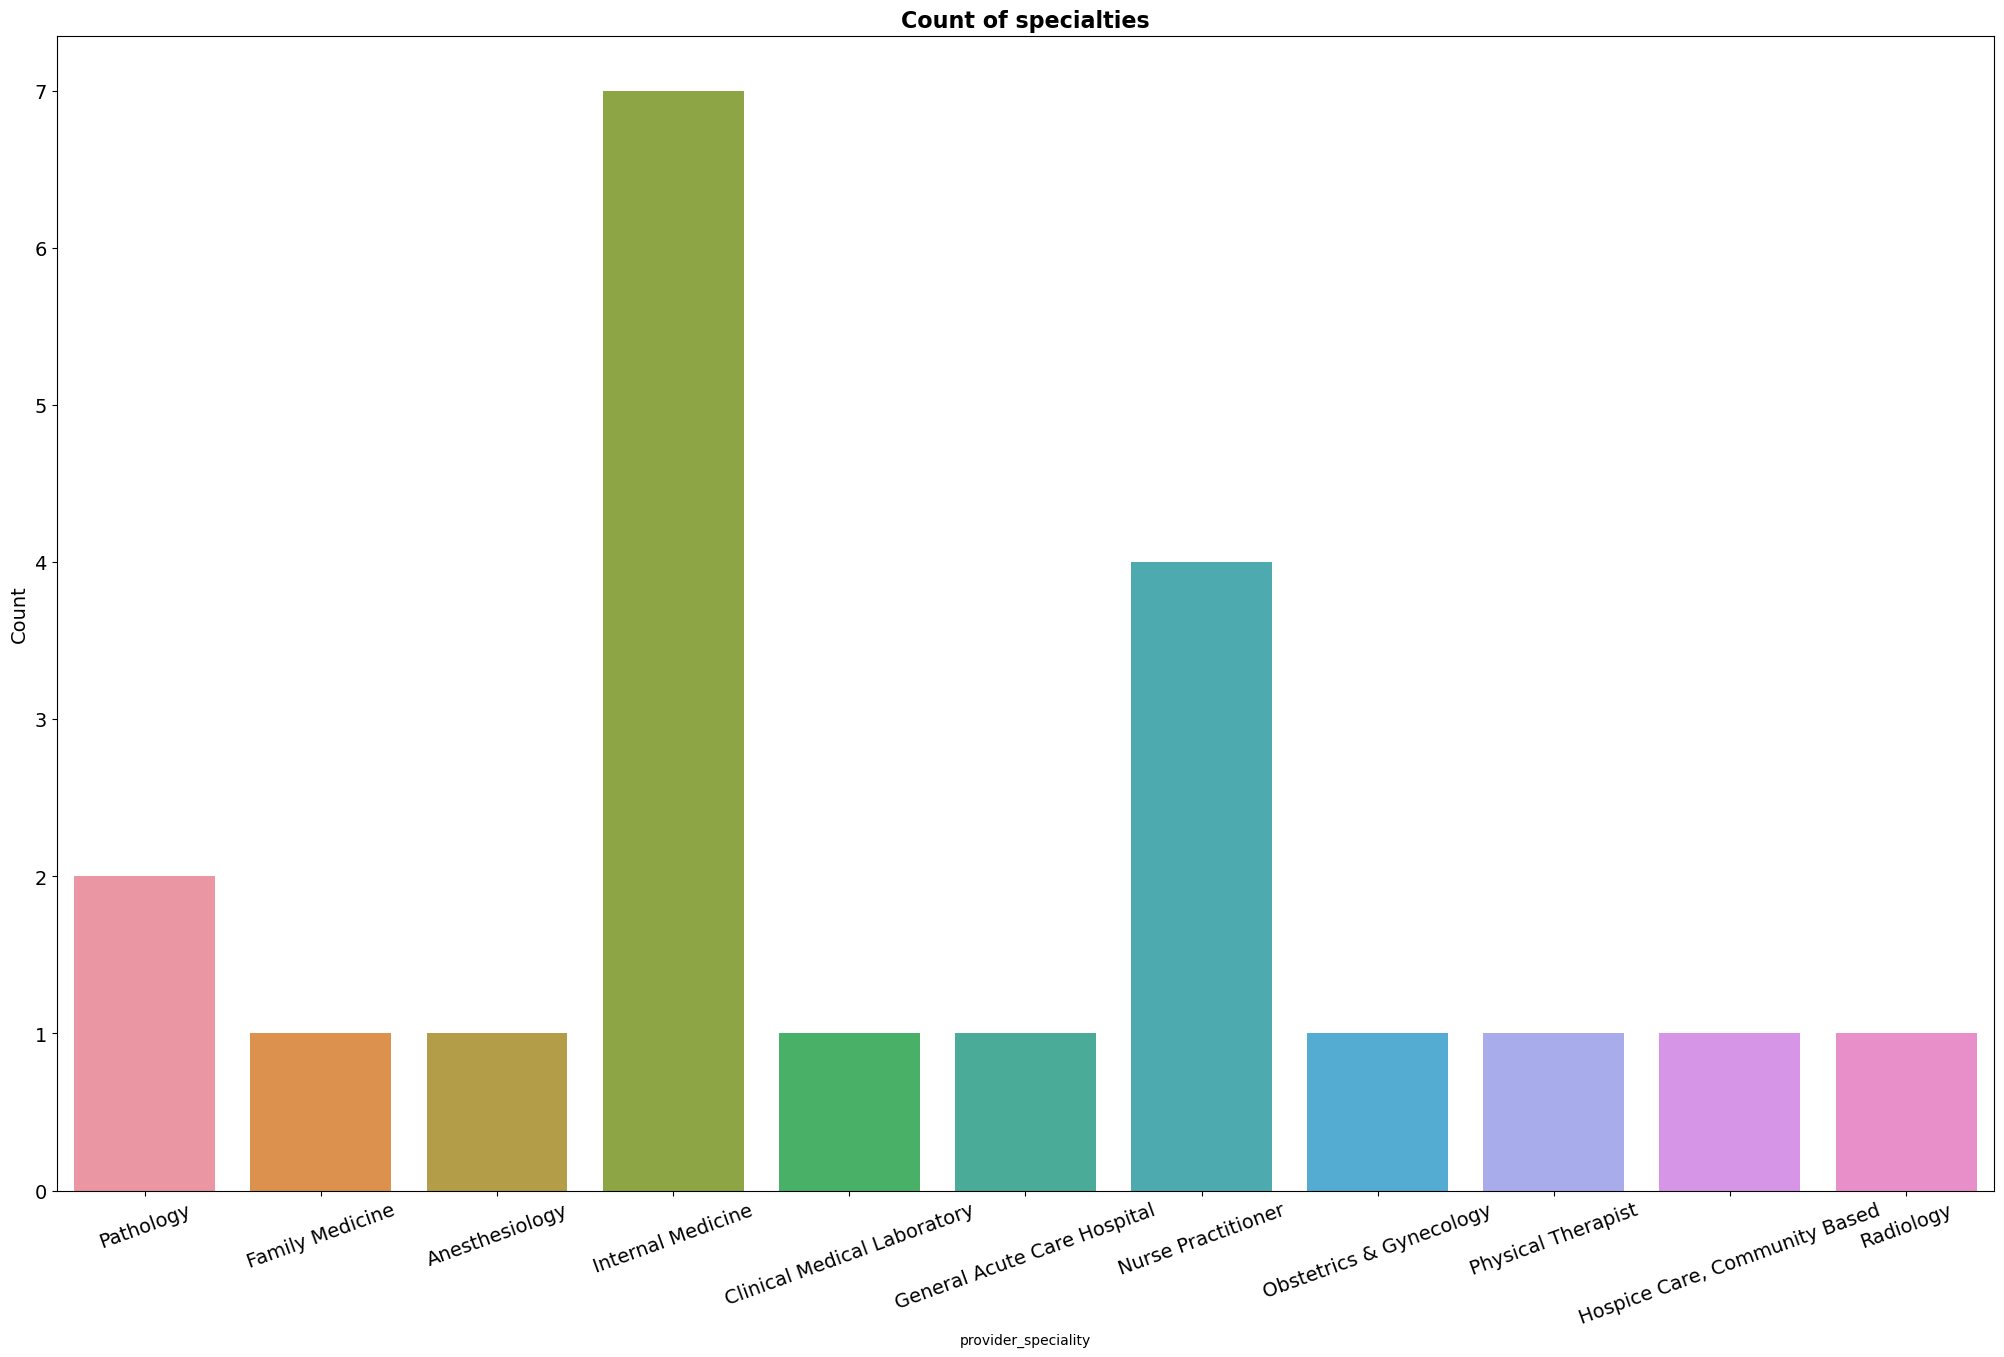

In [269]:
plt.figure(figsize=(25, 15))
sns.countplot(data=more_referrals_tristar, x='provider_specialty')
plt.xticks(rotation=20, fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Count of specialties', fontsize=16, fontweight='bold')
plt.show()

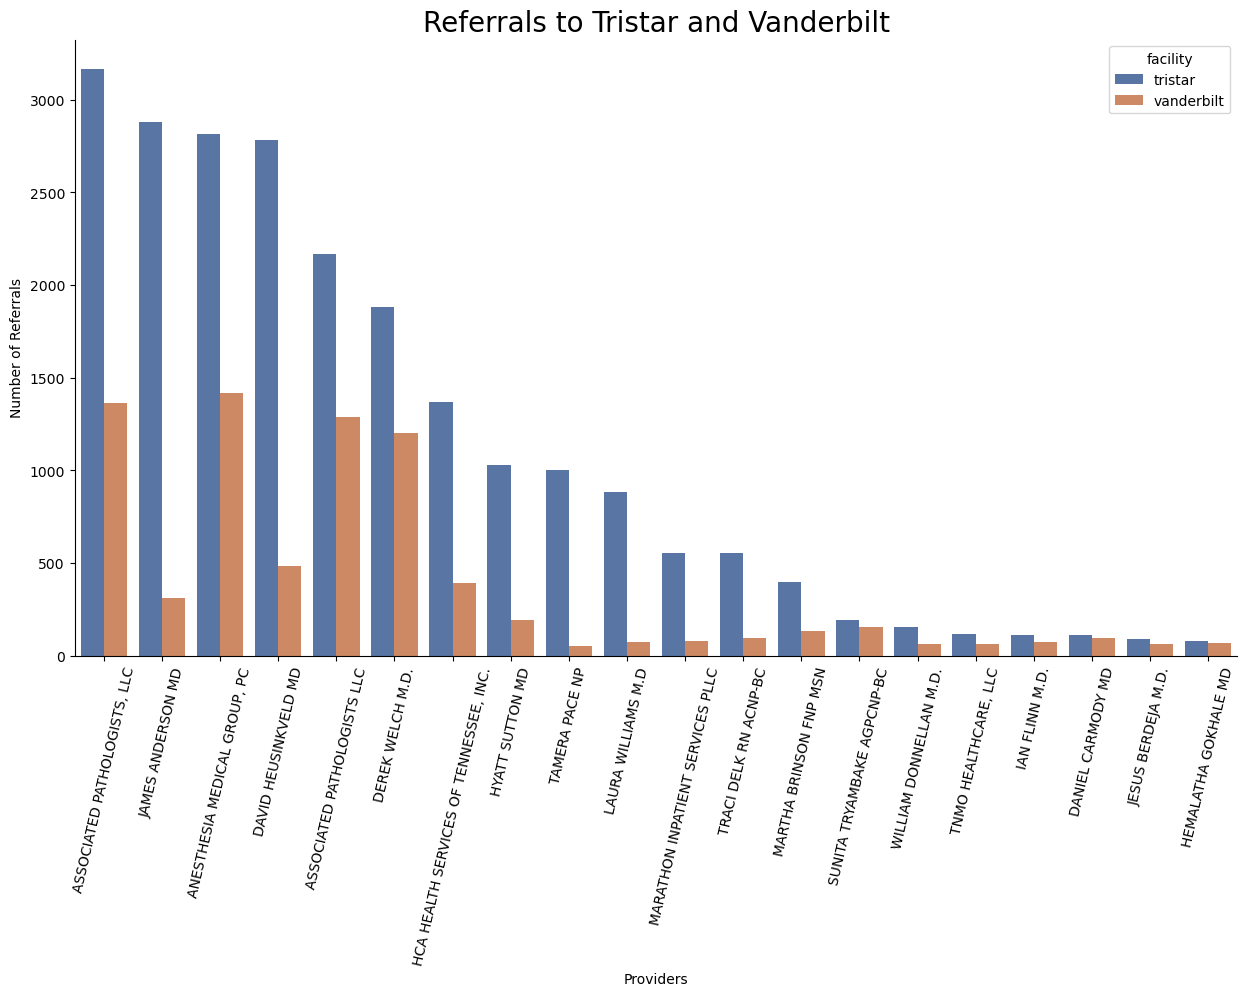

In [257]:
vanderbilt_vs_tristar_plot = pd.DataFrame({ 
    'providers': more_referrals_tristar['referring_provider_or_organization'], 
    'tristar': more_referrals_tristar['referrals_to_tristar'], 
    'vanderbilt': more_referrals_tristar['referrals_to_vanderbilt'] 
}) 


vanderbilt_vs_tristar_plot = pd.melt(vanderbilt_vs_tristar_plot, id_vars = ['providers'], 
                          var_name = 'facility', value_name = 'referrals')


fig, ax = plt.subplots(figsize = (15, 8)) 
sns.despine()
sns.barplot(data = vanderbilt_vs_tristar_plot, x = 'providers', y = 'referrals', hue = 'facility', palette = 'deep', ax = ax)


plt.xticks(rotation =77)


plt.xlabel('Providers')
plt.ylabel('Number of Referrals')
plt.title('Referrals to Tristar and Vanderbilt', fontsize =20)

plt.savefig('vanderbilt_vs_tristar_plot.png', bbox_inches='tight')

plt.show()

In [171]:
merged_df_all['vanderbilt_tristar_percentage'].describe()

count    78.000000
mean      0.712084
std       0.303534
min       0.049289
25%       0.454129
50%       0.897461
75%       0.954851
max       0.998189
Name: vanderbilt_tristar_percentage, dtype: float64

In [172]:
merged_df_all['vanderbilt_tristar_percentage'].median()

0.8974606953330357

In [159]:
merged_df_all['vanderbilt_to_tristar_ratio'].median()

8.752358490566039

In [181]:
merged_df_all.sort_values(by = 'vanderbilt_tristar_percentage', ascending = False)

,referring_npi,provider_speciality,referrals_to_tristar,referrals_to_vanderbilt,referring_provider_or_organization,vanderbilt_to_tristar_ratio,vanderbilt_tristar_percentage
24,1396882205,General Acute Care Hospital,438,241444,VANDERBILT UNIVERSITY MEDICAL CENTER,551.242009,0.998189
18,1104202761,Internal Medicine,592,250678,VANDERBILT UNIVERSITY MEDICAL CENTER,423.442568,0.997644
69,1861479545,General Acute Care Hospital,60,17245,MAURY REGIONAL HOSPITAL,287.416667,0.996533
73,1497828321,Ophthalmology,55,5804,TENNESSEE RETINA PC,105.527273,0.990613
75,1447571658,General Acute Care Hospital,54,2978,SUMNER REGIONAL MEDICAL CENTER LLC,55.148148,0.982190
...,...,...,...,...,...,...,...
27,1871992156,Physical Therapist,330,55,None,0.166667,0.142857
21,1982013728,Internal Medicine,553,81,MARATHON INPATIENT SERVICES PLLC,0.146474,0.127760
3,1184620460,Family Medicine,2882,312,JAMES ANDERSON MD,0.108258,0.097683
16,1457318404,Obstetrics & Gynecology,882,73,LAURA WILLIAMS M.D,0.082766,0.076440


***Consider the specialty of the provider. If Vanderbilt wants to increase volume from Orthopedic Surgeons or from Family Medicine doctors who should they reach out to in those areas?***

In [176]:
merged_npi = tuple(merged_df['referring_npi'].tolist())

In [179]:
# family medicine doctors that vanderbilt should reach out to get their patient referrals.
query = f"""
SELECT "NPI", "Provider Organization Name (Legal Business Name)","Provider First Name" ||' '|| "Provider Last Name (Legal Name)" ||' '|| "Provider Credential Text" AS Fullname, SUM("patient_count") AS "Amount of Patients", SUM("transaction_count") AS Total_referrals
FROM npi_nppes AS nppes
INNER JOIN hop_npi AS npi
ON nppes.NPI = npi.from_npi
WHERE "Classification" = 'Family Medicine' AND "CBSA" = '34980' AND to_npi in {tristar_npi} AND from_npi in {merged_npi}
GROUP BY 1,2,3
ORDER BY 5 DESC;
"""
with sqlite3.connect('../data/npi.sqlite') as db:
    fam_med_to_vanderbilt = pd.read_sql(query, db)

In [180]:
fam_med_to_vanderbilt

,NPI,Provider Organization Name (Legal Business Name),Fullname,Amount of Patients,Total_referrals


In [178]:
fam_med_to_vanderbilt = fam_med_to_vanderbilt.replace('None', pd.NA)
fam_med_to_vanderbilt['provider_name']= fam_med_to_vanderbilt['Fullname'].fillna(fam_med_to_vanderbilt['Provider Organization Name (Legal Business Name)'])
fam_med_to_vanderbilt = fam_med_to_vanderbilt.drop(['Provider Organization Name (Legal Business Name)', 'Fullname'], axis = 1)
fam_med_to_vanderbilt

,NPI,Amount of Patients,Total_referrals,provider_name


In [116]:
# Orthopaedic surgeons that vanderbilt should reach out to get their patient referrals.
query = f"""
SELECT "NPI", "Provider Organization Name (Legal Business Name)","Provider First Name" ||' '|| "Provider Last Name (Legal Name)" ||' '|| "Provider Credential Text" AS Fullname, SUM("patient_count") AS "Amount of Patients", SUM("transaction_count") AS Total_referrals
FROM npi_nppes AS nppes
INNER JOIN hop_npi AS npi
ON nppes.NPI = npi.from_npi
WHERE "Classification" = 'Orthopaedic Surgery' AND "CBSA" = '34980' AND to_npi in {tristar_npi} AND from_npi in {merged_npi}
GROUP BY 1,2,3
ORDER BY 5 DESC;
"""
with sqlite3.connect('../data/npi.sqlite') as db:
    ortho_surg_to_vanderbilt = pd.read_sql(query, db)
    

In [117]:
ortho_surg_to_vanderbilt = ortho_surg_to_vanderbilt.replace('None', pd.NA)
ortho_surg_to_vanderbilt['provider_name']= ortho_surg_to_vanderbilt['Fullname'].fillna(ortho_surg_to_vanderbilt['Provider Organization Name (Legal Business Name)'])
ortho_surg_to_vanderbilt = ortho_surg_to_vanderbilt.drop(['Provider Organization Name (Legal Business Name)', 'Fullname'], axis = 1)
ortho_surg_to_vanderbilt

,NPI,Amount of Patients,Total_referrals,provider_name


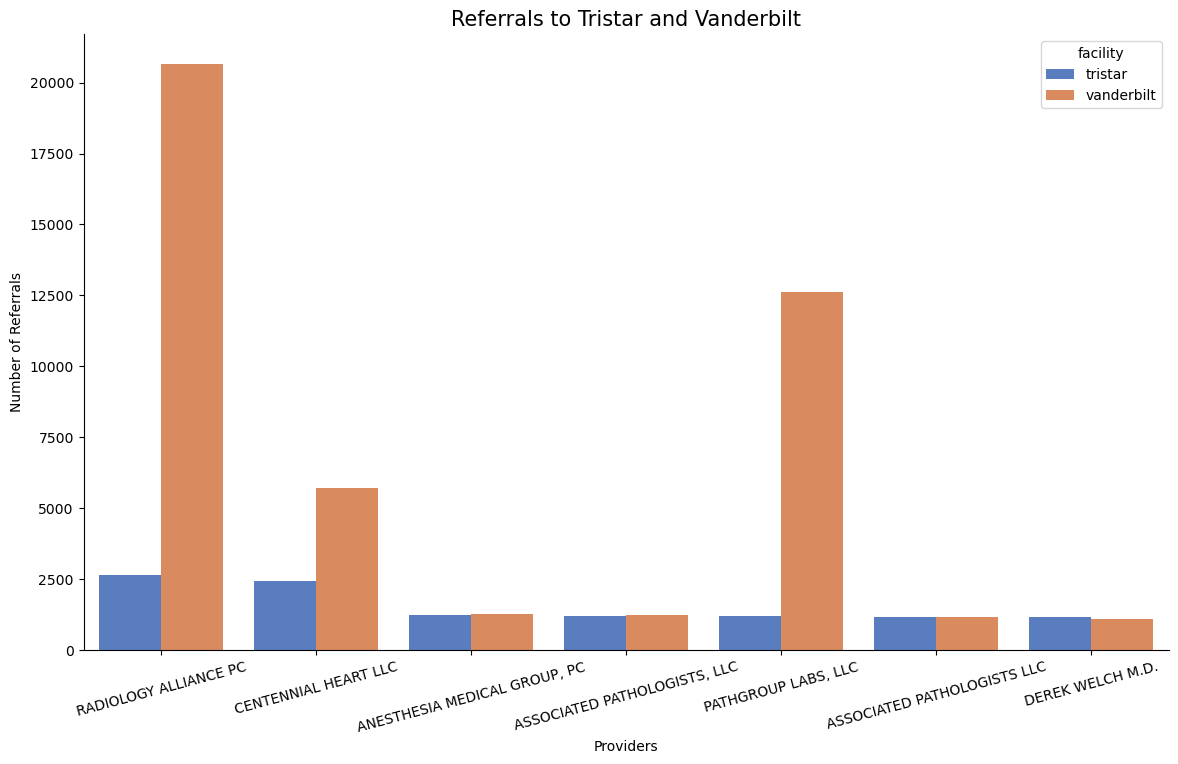

In [123]:
# This plot shows providers how have given atleast 1000 referrals to either Vanderbilt or Tristar

vanderbilt_vs_tristar_plot = pd.DataFrame({ 
    'providers': merged_df['referring_provider_or_organization'], 
    'tristar': merged_df['referrals_to_tristar'], 
    'vanderbilt': merged_df['referrals_to_vanderbilt'] 
}) 


vanderbilt_vs_tristar_plot = pd.melt(vanderbilt_vs_tristar_plot, id_vars=['providers'], 
                          var_name='facility', value_name='referrals')


fig, ax = plt.subplots(figsize=(14, 8)) 
sns.despine()
sns.barplot(data=vanderbilt_vs_tristar_plot, x='providers', y='referrals', hue='facility', palette='muted', ax=ax)


plt.xticks(rotation=15)


plt.xlabel('Providers')
plt.ylabel('Number of Referrals')
plt.title('Referrals to Tristar and Vanderbilt', fontsize=15)

plt.savefig('vanderbilt_vs_tristar_plot.png', bbox_inches='tight')



plt.show()

In [ ]:
merged_df.to_csv("../data/tristar_vandy.csv")


In [ ]:
#query getting the data needed to create a csv for neo4j
query = """
SELECT * 
FROM npi_nppes as np
join hop_npi as n
on np.NPI = n.from_npi
WHERE np.CBSA = 34980

"""
with sqlite3.connect('../data/npi.sqlite') as db:
    nppes_nashville = pd.read_sql(query, db)

In [ ]:
#Creating a csv to load into neo4j
nppes_nashville.to_csv("../data/nppes_nashville.csv")

In [ ]:
# query = """
# SELECT COUNT(*)
# FROM npi_nppes 

# """
# with sqlite3.connect('../data/npi.sqlite') as db:
#     check = pd.read_sql(query, db)
#check

In [ ]:
#table with the correct Vanderbilt organization
#query = """
#SELECT *
#FROM npi_nppes
#WHERE "Provider Organization Name (Legal Business Name)" = 'VANDERBILT UNIVERSITY MEDICAL CENTER'
#"""
#with sqlite3.connect('../data/npi.sqlite') as db:
    #The_vanderbilt = pd.read_sql(query, db)
    
#The_vanderbilt

In [ ]:
#Finding TriStar Centennial Medical Center ONLY in Nashville area
# query = """
# SELECT "Provider Organization Name (Legal Business Name)","NPI","Provider First Line Business Practice Location Address", SUM("patient_count") AS "Amount of Patients", SUM("transaction_count") AS Total_referrals
# FROM npi_nppes AS nppes
# INNER JOIN hop_npi AS npi
# ON nppes.NPI = npi.from_npi
# WHERE "CBSA" = '34980' AND "Provider Organization Name (Legal Business Name)" LIKE '%TriStar%'
# GROUP BY 1,2,3
# """
# with sqlite3.connect('../data/npi.sqlite') as db:
#     finding_tristar = pd.read_sql(query, db)
    
# finding_tristar